In [3]:
import math
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'c:\Users\patri\Downloads\sim_parameters_historical_combined.csv')

def average_direction(degree_list):
    """Calculate the average direction in degrees"""
    sin_sum = sum(math.sin(math.radians(d)) for d in degree_list)
    cos_sum = sum(math.cos(math.radians(d)) for d in degree_list)
    sin_avg = sin_sum / len(degree_list)
    cos_avg = cos_sum / len(degree_list)
    avg_angle = math.degrees(math.atan2(sin_avg, cos_avg))
    return avg_angle % 360

def wind_vector_by_altitude(df, altitude):
    """Returns (avg_direction, avg_speed) for a given altitude"""
    direction_col = f'direction [{altitude}]'
    speed = str(altitude)
    
    avg_direction = average_direction(df[direction_col].tolist())
    avg_speed = df[speed].mean()

    return (avg_direction, avg_speed)

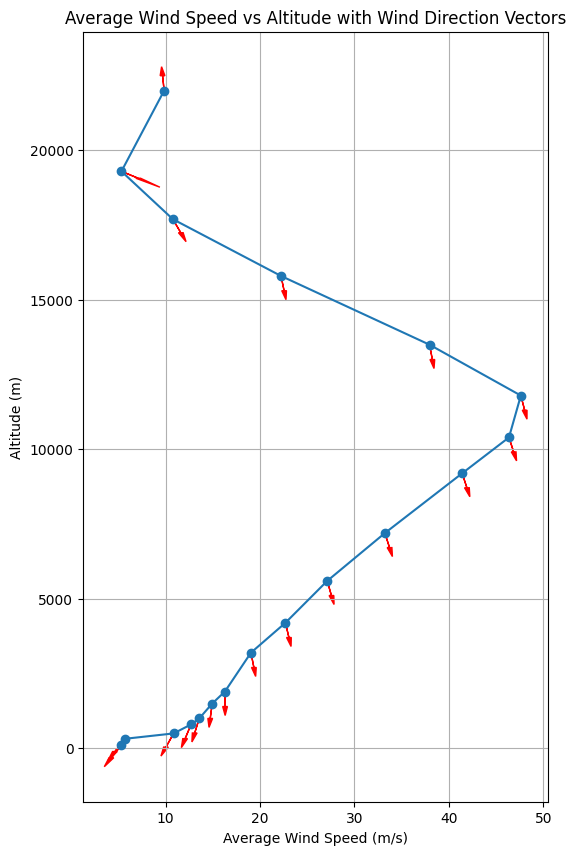

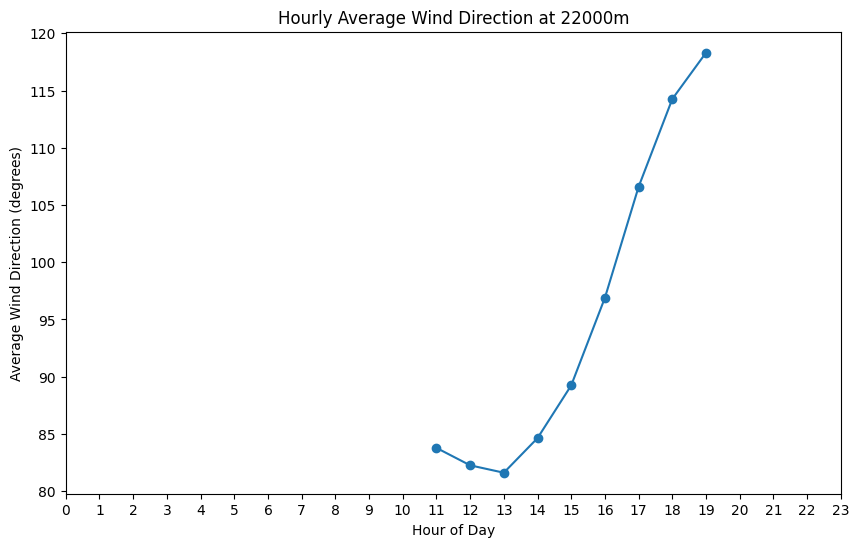

In [27]:
df['hour'] = pd.to_datetime(df['date'], format ='mixed').dt.hour
df['date_only'] = pd.to_datetime(df['date'], format ='mixed').dt.date
wind_speed_cols = [col for col in df.columns if 'stdev' not in col and 'direction' not in col and col not in ['date', 'temperature', 'pressure', 'hour', 'date_only']]
avg_wind_speeds = df[wind_speed_cols].mean()
altitudes = [int(col) for col in wind_speed_cols]

# Plot avg wind speed vs altitude with direction vectors
plt.figure(figsize=(6,10))
plt.plot(avg_wind_speeds, altitudes, marker='o')
arrow_scale_x = 2
arrow_scale_y = 500

for i, alt in enumerate(altitudes):
    speed = avg_wind_speeds.iloc[i]
    direction, _ = wind_vector_by_altitude(df, alt)

    arrow_x = math.cos(math.radians(direction)) * arrow_scale_x
    arrow_y = math.sin(math.radians(direction)) * arrow_scale_y

    plt.arrow(speed, alt, arrow_x, arrow_y, head_width=0.5, head_length=300, fc='red', ec='red')

plt.xlabel('Average Wind Speed (m/s)')
plt.ylabel('Altitude (m)')
plt.title('Average Wind Speed vs Altitude with Wind Direction Vectors')
plt.grid(True)
plt.show()

# Plot avg wind direction at different altitudes by hour of day

# Plot avg wind direction at a specific altitude (e.g, 1000m) and time (e.g, 12:00)
altitude = 22000
direction_col = f'direction [{altitude}]'

avg_direction_by_hour = df.groupby('hour')[direction_col].apply(lambda dirs: average_direction(dirs.tolist()))

plt.figure(figsize=(10, 6))
plt.plot(avg_direction_by_hour.index, avg_direction_by_hour.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Wind Direction (degrees)')
plt.title(f'Hourly Average Wind Direction at {altitude}m')
plt.xticks(range(0, 24))
plt.show()

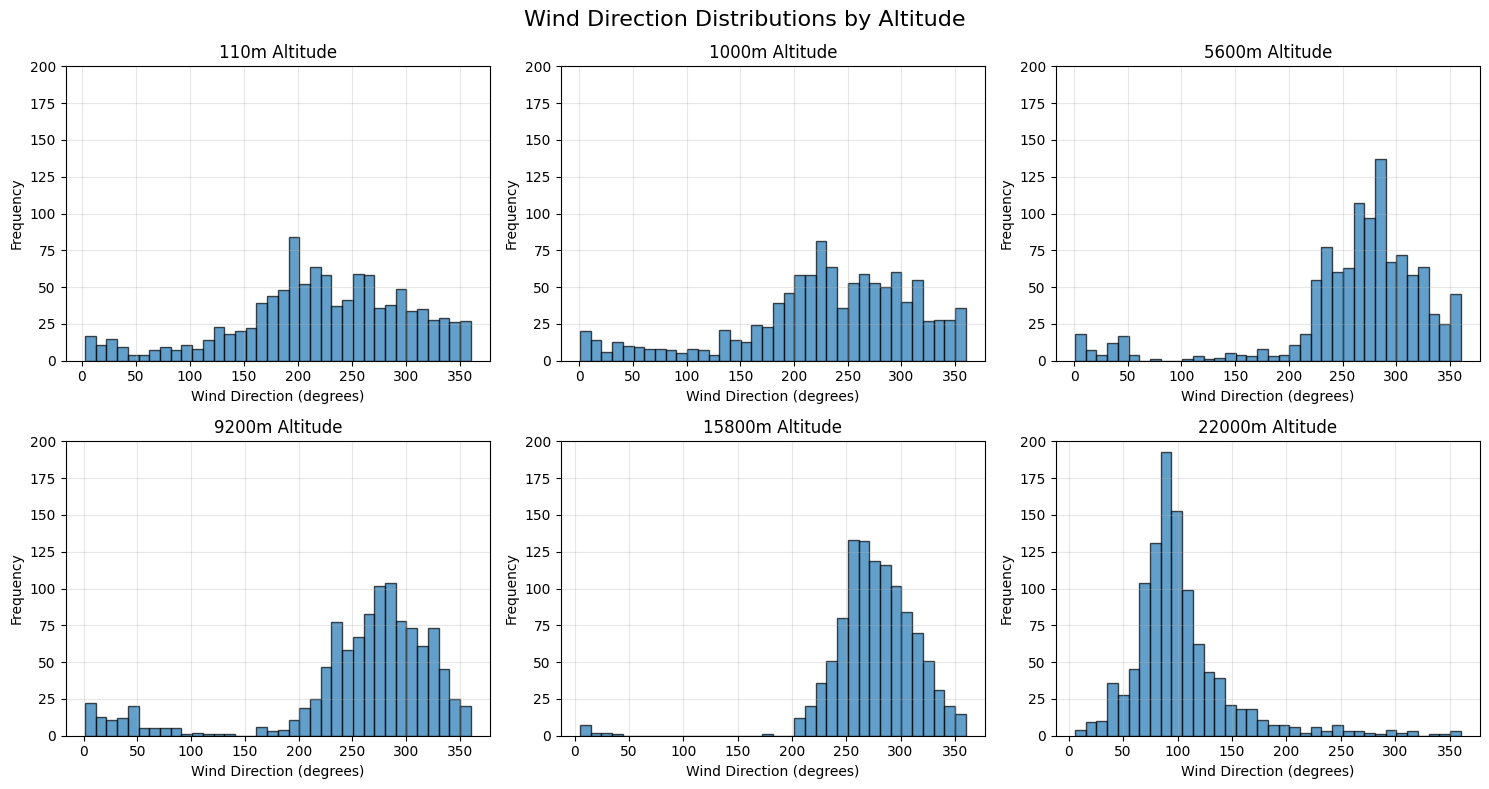

In [ ]:
altitudes = [110, 1000, 5600, 9200, 15800, 22000]

# distribution of wind directions at different altitudes

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, alt in enumerate(altitudes):
    axes[i].hist(df[f'direction [{alt}]'], bins=36, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel('Wind Direction (degrees)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{alt}m Altitude')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 200)

plt.suptitle('Wind Direction Distributions by Altitude', fontsize=16)
plt.tight_layout()
plt.show()  

In [51]:
from astropy.stats import circmean, circstd
from scipy.stats import vonmises
import numpy as np

altitudes = [110, 1000, 5600, 9200, 15800, 22000]

for i, alt in enumerate(altitudes):

    directions = df[f'direction [{alt}]'].dropna()

    directions_rad = np.radians(directions)

    # vonmises.fit returns (kappa, loc, scale) but we only care about kappa and loc
    kappa, loc, scale = vonmises.fit(directions_rad, fscale=1)

    mean_direction = np.degrees(loc) % 360

    print(f"Altitude {alt}m:")
    print(f"  Mean direction: {mean_direction:.1f}°")
    print(f"  Kappa (concentration): {kappa:.2f}")
    print(f"  Higher Kappa = more concentrated winds")
    print()

Altitude 110m:
  Mean direction: 237.9°
  Kappa (concentration): 0.91
  Higher Kappa = more concentrated winds

Altitude 1000m:
  Mean direction: 256.1°
  Kappa (concentration): 1.03
  Higher Kappa = more concentrated winds

Altitude 5600m:
  Mean direction: 283.0°
  Kappa (concentration): 2.08
  Higher Kappa = more concentrated winds

Altitude 9200m:
  Mean direction: 284.5°
  Kappa (concentration): 1.88
  Higher Kappa = more concentrated winds

Altitude 15800m:
  Mean direction: 279.4°
  Kappa (concentration): 3.58
  Higher Kappa = more concentrated winds

Altitude 22000m:
  Mean direction: 94.9°
  Kappa (concentration): 2.77
  Higher Kappa = more concentrated winds



In [ ]:
from astropy.stats import rayleightest

print("Rayleigh Test for Wind Direction Uniformity")
print()
print("Tests if winds have a preferred direction vs random")
print()

altitudes = [110, 1000, 5600, 9200, 15800, 22000]

for alt in altitudes:
    directions = df[f'direction [{alt}]'].dropna()
    directions_rad = np.radians(directions)
    
    p_value = rayleightest(directions_rad)
    
    print(f"Altitude {alt}m:")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Result: {'Preferred direction' if p_value < 0.05 else 'Random/Uniform'}")
    print()

Rayleigh Test for Wind Direction Uniformity

Tests if winds have a preferred direction vs. random

Altitude 110m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 1000m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 5600m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 9200m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 15800m:
  p-value: 0.000000
  Result: Preferred direction

Altitude 22000m:
  p-value: 0.000000
  Result: Preferred direction



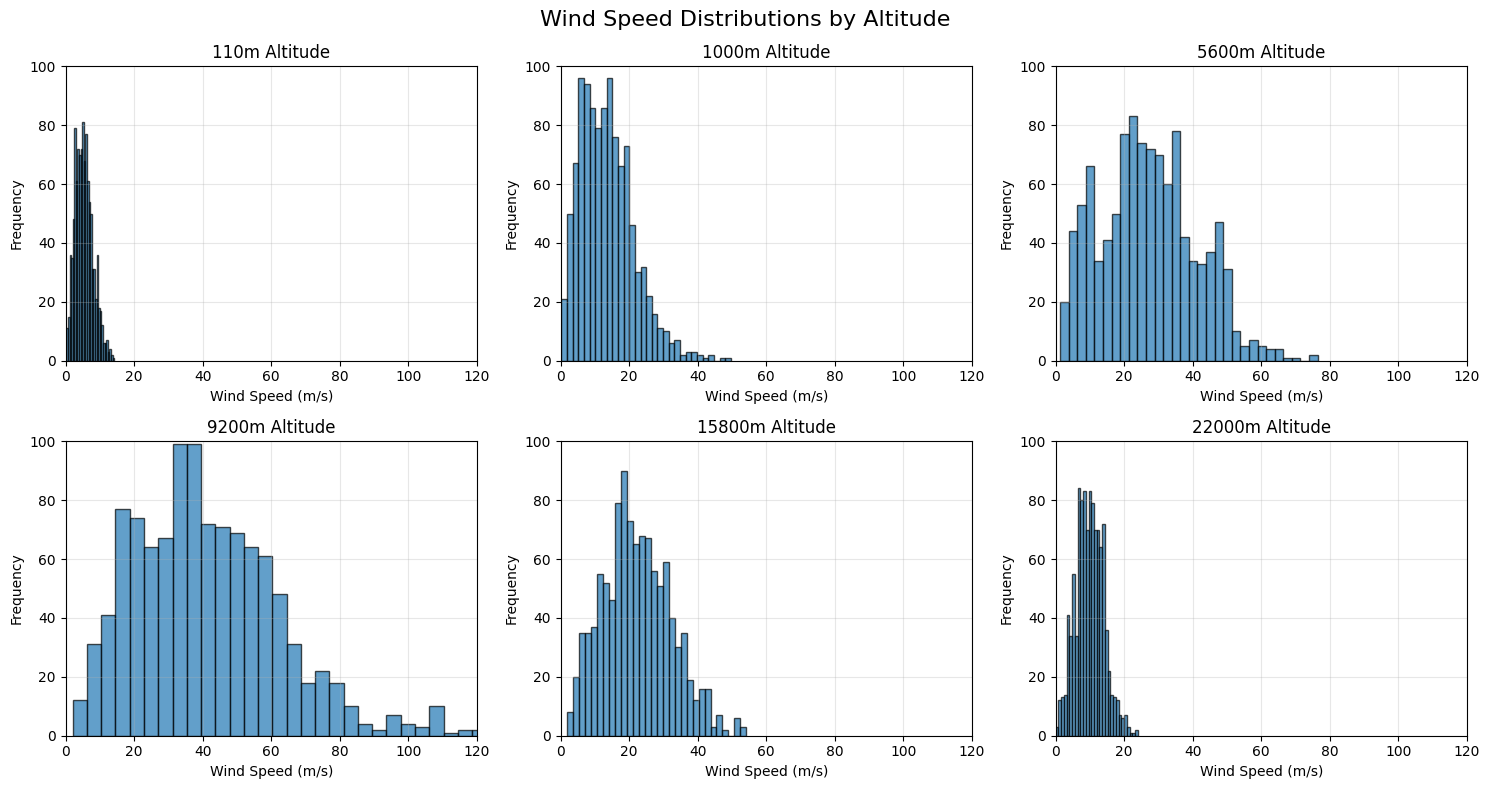

In [53]:
altitudes = [110, 1000, 5600, 9200, 15800, 22000]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, alt in enumerate(altitudes):
    speeds = df[str(alt)].dropna()
    axes[i].hist(speeds, bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel('Wind Speed (m/s)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{alt}m Altitude')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim(0, 120)
    axes[i].set_ylim(0, 100)

plt.suptitle('Wind Speed Distributions by Altitude', fontsize=16)
plt.tight_layout()
plt.show()

In [54]:
from scipy.stats import weibull_min

altitudes = [110, 1000, 5600, 9200, 15800, 22000]

for alt in altitudes:
    speeds = df[str(alt)].dropna()
    
    # returns (shape, loc, scale) and we only care about shape and scale
    shape, loc, scale = weibull_min.fit(speeds, floc=0)
    
    print(f"Altitude {alt}m:")
    print(f"  Shape (k): {shape:.2f}")
    print(f"  Scale (λ): {scale:.2f}")
    print(f"  Mean speed: {speeds.mean():.2f} m/s")
    print()

Altitude 110m:
  Shape (k): 2.17
  Scale (λ): 6.02
  Mean speed: 5.33 m/s

Altitude 1000m:
  Shape (k): 1.80
  Scale (λ): 15.27
  Mean speed: 13.57 m/s

Altitude 5600m:
  Shape (k): 2.01
  Scale (λ): 30.55
  Mean speed: 27.12 m/s

Altitude 9200m:
  Shape (k): 2.02
  Scale (λ): 46.80
  Mean speed: 41.42 m/s

Altitude 15800m:
  Shape (k): 2.39
  Scale (λ): 25.09
  Mean speed: 22.23 m/s

Altitude 22000m:
  Shape (k): 2.63
  Scale (λ): 11.09
  Mean speed: 9.86 m/s



In [55]:
print("Weibull Goodness-of-Fit Tests (Wind Speed)")
print()

for alt in altitudes:
    speeds = df[str(alt)].dropna()
    
    shape, loc, scale = weibull_min.fit(speeds, floc=0)
    
    ks_stat, p_value = kstest(speeds, lambda x: weibull_min.cdf(x, shape, loc, scale))
    
    print(f"Altitude {alt}m:")
    print(f"  KS statistic: {ks_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Fit quality: {'GOOD' if p_value > 0.05 else 'POOR'}")
    print()

Weibull Goodness-of-Fit Tests (Wind Speed)

Altitude 110m:
  KS statistic: 0.0150
  p-value: 0.9637
  Fit quality: GOOD

Altitude 1000m:
  KS statistic: 0.0223
  p-value: 0.6465
  Fit quality: GOOD

Altitude 5600m:
  KS statistic: 0.0457
  p-value: 0.0208
  Fit quality: POOR

Altitude 9200m:
  KS statistic: 0.0240
  p-value: 0.5512
  Fit quality: GOOD

Altitude 15800m:
  KS statistic: 0.0199
  p-value: 0.7750
  Fit quality: GOOD

Altitude 22000m:
  KS statistic: 0.0293
  p-value: 0.3052
  Fit quality: GOOD



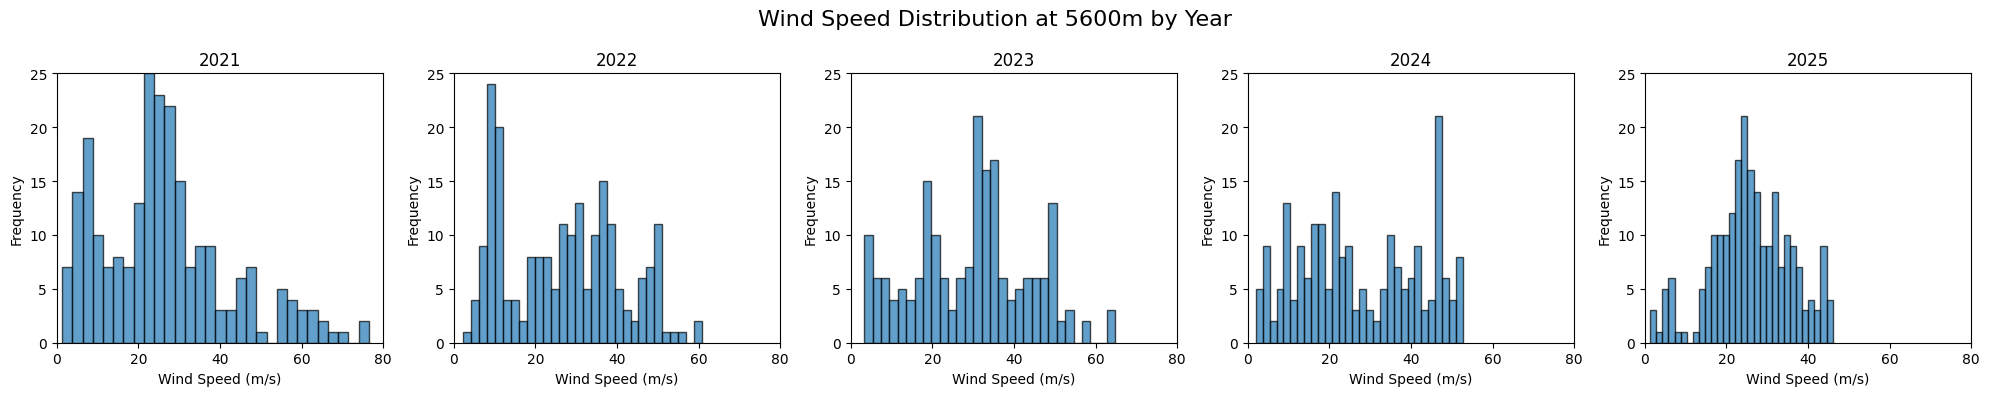

In [50]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, year in enumerate(sorted(df['year'].unique())):
    year_speeds = df[df['year'] == year][str(5600)].dropna()
    axes[i].hist(year_speeds, bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel('Wind Speed (m/s)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{year}')
    axes[i].set_xlim(0, 80)
    axes[i].set_ylim(0, 25)

plt.suptitle('Wind Speed Distribution at 5600m by Year', fontsize=16)
plt.tight_layout()
plt.show()